In [2]:
from __future__ import print_function
from __future__ import division
from gensim.models import Doc2Vec, Word2Vec
import lib.text_extraction as te
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from lib.parallelize import parallelize
from collections import OrderedDict
import lib.embedding as em
import lib.words as wd
import pandas as pd
import numpy as np
import pickle
import operator
import codecs
import math
import json
import csv
import os
import re

matplotlib.style.use('ggplot')
%matplotlib inline

labels = ['poteri', 'scadenza', 'assemblea', 'clausola', 'non_riconducibile']

Using TensorFlow backend.


## Sentencing

In [3]:
def list_dir_full(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [3]:
test_dir = '../extraction/esempi_descrizioni/'

filenames = os.listdir(test_dir)
full_filenames = list_dir_full(test_dir)

#txts = [te.extract_text(f, do_ocr=False, pages=-1) for f in full_filenames]

txts = parallelize(te.extract_text)(full_filenames, do_ocr=False, pages=-1) #Doesn't work with do_ocr=True

In [ ]:
for i, txt in zip(filenames, txts):
    print('Documento ', i)
    print(txt[:1000])

In [ ]:
extracted_txts_dir = '../extraction/esempi_extracted/'

for fn, txt in zip(filenames, txts):
    utxt = wd.to_utf8(txt)
    with codecs.open(os.path.join(extracted_txts_dir, fn[:-3])+'txt', 'w', encoding='utf-8') as o:
        o.write(utxt)


In [ ]:
sentences_dir = '../extraction/esempi_sentences/'

sentences = [wd.sentences_doc(txt) for txt in txts]

for fn, txt in zip(filenames, sentences):
    with codecs.open(os.path.join(sentences_dir, fn[:-3])+'txt', 'w', encoding='utf-8') as o:
        o.write('\n'.join(s.replace('\n',' ').strip() for s in txt if s.strip()))

## Saving sentences

In [ ]:
sentenced_txts = [wd.sentences_doc(txt) for txt in txts]

In [ ]:
def sentence_label_csv_empty(filenames, sentenced_txts, csv_out, sep=u'\t', min_len=10):
    csv_out.write(sep.join([u'filename',u'sent_index',u'sentence',u'label']) + u'\n')
    for f, sents in zip(filenames, sentenced_txts):
        for i, sent in enumerate(sents):
            clean_sent = sent.replace(sep,u'').replace(u'\n',u' ').strip()
            if len(clean_sent)>=min_len:
                csv_out.write(sep.join([u'{}',u'{}',u'{}',u'non_riconducibile']).format(f,i,clean_sent)+u'\n')
    

In [ ]:
csv_filename = '../extraction/sentence_labels.csv'
with codecs.open(csv_filename, 'w', encoding='utf-8') as csv_out:
    sentence_label_csv_empty(os.listdir(test_dir), sentenced_txts, csv_out)

In [ ]:
df = pd.read_csv(csv_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [13]:
df.groupby(['filename'])['sentence'].apply(list).to_dict()

NameError: name 'df' is not defined

In [ ]:
labelled_filename = '../extraction/sentence_manual_labels.csv'
dfm = pd.read_csv(labelled_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

## Save to excel files

In [ ]:
def sentences_to_excel(sentences, filename, out_dir, sep=u'\t', min_len=10):
    clean_sents = [sent.replace(sep,u'').replace(u'\n',u' ').strip() for sent in sentences]
    clean_sents = [sent for sent in clean_sents if len(sent)>=min_len]
    df = pd.DataFrame({'sentence':clean_sents,'label':['non_riconducibile']*len(clean_sents)})
    df.to_excel(os.path.join(out_dir, os.path.basename(filename)[:-3]+'xlsx'), index=False, encoding='utf-8')

In [ ]:
files_to_label = [f for f in list_dir_full('../extraction/files_to_label/') if f.endswith('.pdf')]
txts_to_label = [te.extract_text(f, do_ocr=True, pages=-1) for f in files_to_label]
sentences_to_label = [wd.sentences_doc(txt) for txt in txts_to_label]

In [ ]:
for f, s in zip(files_to_label, sentences_to_label):
    sentences_to_excel(s, f, '../extraction/excels_to_label/')

In [4]:
dfm = pd.read_csv('../extraction/sentence_manual_labels3.csv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [31]:
snts = dfm.groupby('filename')['sentence'].apply(list)
lbls = dfm.groupby('filename')['label'].apply(list)
for f in snts.keys():
    cur_df = pd.DataFrame({'sentence':snts.loc[f],
                            'label':['non_riconducibile' if l == 'non_rilevante' else l for l in lbls.loc[f]]})
    cur_df.to_excel('../extraction/excels_labelled_from_csv/'+f+'.xlsx', index=False, encoding='utf-8')

In [33]:
def build_dataframe_from_excels(filenames):
    dfs = [pd.read_excel(f, encoding='utf-8') for f in filenames]
    filename_col = [os.path.basename(f)[:-4]+'pdf' for f,df in zip(filenames, dfs) for _ in range(df.shape[0])]
    sent_index_col = [i for df in dfs for i in range(df.shape[0])]
    dfs_conc = pd.concat(dfs, ignore_index=True, axis=0)
    sentence_col = dfs_conc['sentence']
    label_col = dfs_conc['label']
    #print('{} {} {} {}'.format(len(filename_col), len(sent_index_col), len(sentence_col), len(label_col)))
    return pd.DataFrame(OrderedDict([
        ('filename',filename_col),
        ('sent_index', sent_index_col),
        ('sentence', sentence_col),
        ('label', label_col)
    ]))

In [102]:
dfx = build_dataframe_from_excels([f for f in list_dir_full('../extraction/excels_labelled/') if f.endswith('.xlsx')])

In [103]:
len([f for f in list_dir_full('../extraction/excels_labelled/') if f.endswith('.xlsx')])

20

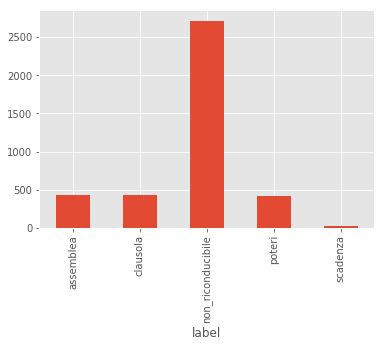

In [104]:
#dfx.groupby(['filename', 'label']).count()
dfx.groupby('label').count()['filename'].plot.bar()
#dfx.loc[dfx['label'] != 'non_riconducibile'].groupby('label').count()['filename'].plot.pie()

In [105]:
dfx.to_csv('../extraction/merged_xlsx.csv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE, index=False)

## Experiments on labelled sentences

In [106]:
def cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def splitted_words_lower(sentences):
    return [[w.lower() for w in wd.splitted_words_utf8(s)] for s in sentences]


In [107]:
labeled_csv_filename = '../extraction/merged_xlsx.csv' #'../extraction/sentence_manual_labels3.csv'

ldf = pd.read_csv(labeled_csv_filename, sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

In [108]:
ldf.groupby('label').count()

,filename,sent_index,sentence
label,,,
assemblea,428,428,428
clausola,432,432,432
non_riconducibile,2714,2714,2714
poteri,421,421,421
scadenza,20,20,20


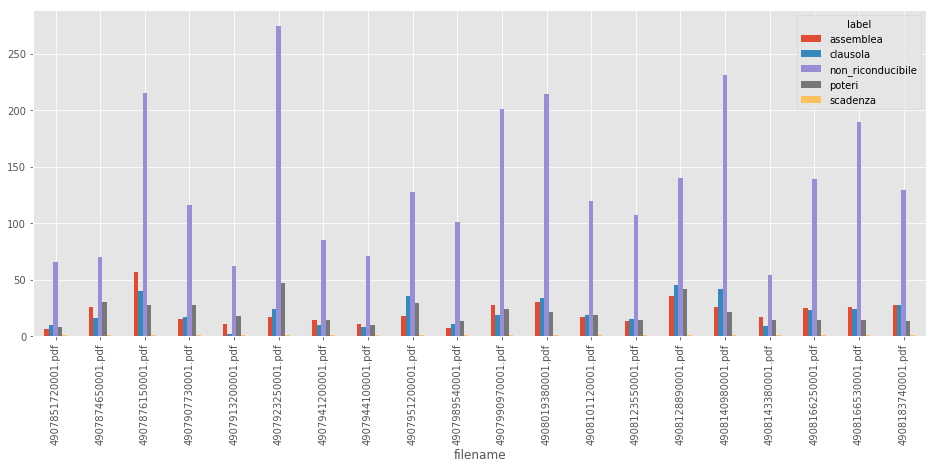

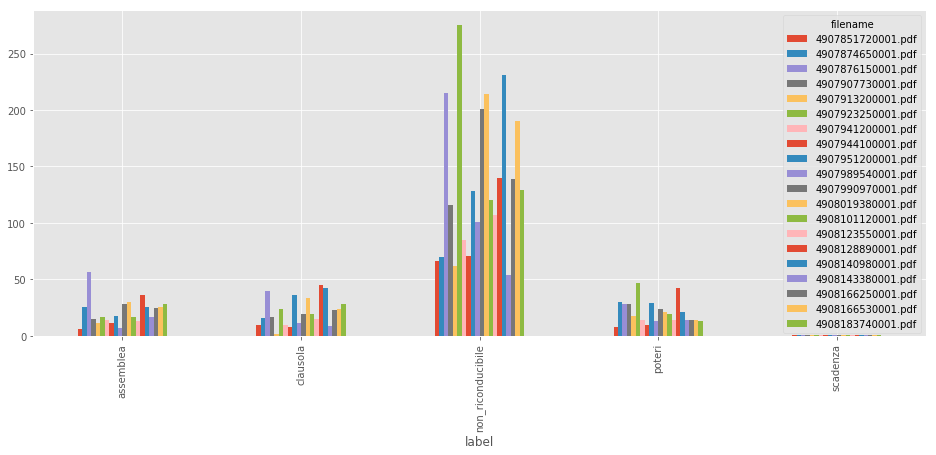

In [109]:
df25 = ldf.groupby(['filename', 'label']).size().reset_index(name="Count")
df35 = pd.pivot_table(df25,  values='Count',  columns=['label'], index='filename')
df45 = pd.pivot_table(df25,  values='Count',  columns=['filename'], index='label')
df35.plot(kind="bar", figsize=(16,6))
plt.show()
df45.plot(kind="bar", figsize=(16,6))
plt.show()

## Sentence Word embedding

In [110]:
splitted_sentences = wd.tokenize_sentences(ldf['sentence'], min_words=1)
labels_sentences = [labels.index(l) for l in ldf['label']]
print('Sentences: {}\nLabels: {}'.format(len(splitted_sentences), len(labels_sentences)))

Sentences: 4015
Labels: 4015


In [111]:
fnw = em.first_n_words(splitted_sentences, 4998)
permitted_words = [e[0] for e in fnw]
reduced_sentences = list(em.reduce_dictionary(splitted_sentences, permitted_words, min_words=1))
reduced_dictionary = em.build_dictionary(reduced_sentences, start_index=1) #start from 1, 0 is padding!
int_sentences = [[reduced_dictionary[w] for w in sent] for sent in reduced_sentences]

In [112]:
np.percentile([len(s) for s in int_sentences], 99.9)

111.80400000000463

In [113]:
max(reduced_dictionary.values())

4999

In [114]:
reduced_dictionary

{u'utilizzata': 2150,
 u'recepite': 312,
 u'pi\xf9': 4529,
 u'utilizzate': 878,
 u'rinunziare': 2683,
 u'comunque': 565,
 u'cinematografici': 4735,
 u'motivazione': 1568,
 u'unico': 318,
 u'consiste': 3157,
 u'convegni': 3727,
 u'speculazione': 611,
 u'attribuire': 2789,
 u'merceologiche': 3663,
 u'francesco': 218,
 u'assemblea': 326,
 u'francesca': 2844,
 u'nega': 1194,
 u'assemblee': 1151,
 u'stratore': 1831,
 u'taio': 2981,
 u'riservata': 3483,
 u'presenta': 2969,
 u'presente': 97,
 u'egli': 3104,
 u'determinando': 2126,
 u'fiscali': 4270,
 u'presenti': 841,
 u'ali': 3619,
 u'compiler\xe0': 1686,
 u'posteriori': 4023,
 u'seguire': 3595,
 u'considera': 1411,
 u'firmato': 2169,
 u'fronte': 979,
 u'semprech\xe8': 3300,
 u'firmati': 2228,
 u'cenacoli': 710,
 u'emme': 4227,
 u'carapelle': 2188,
 u'sostituiti': 4980,
 u'eseguirne': 3965,
 u'qualificato': 4294,
 u'derogate': 3191,
 u'capua': 4223,
 u'consortili': 3734,
 u'commerce': 4664,
 u'mutualistiche': 2406,
 u'consortile': 4828,
 u'd

In [115]:
with open('../extraction/dataset.p', 'wb') as o:
    pickle.dump([int_sentences, labels_sentences], o)

In [129]:
ldf[['sentence','label']] # if u'primo esercizio' in l[0]

,sentence,label
0,Repertorio n47163 Raccolta n20658 ATTO COSTITU...,non_riconducibile
1,"Gli stessi comparenti, con il presente atto, c...",non_riconducibile
2,"I) Viene costituita, in conformità al disposto...",non_riconducibile
3,Per espressa previsione della compagine social...,non_riconducibile
4,"La società risulta essere, altresì, come unani...",non_riconducibile
5,"1 Dott Ambrogio Romano NOTAIO Inoltre, come de...",non_riconducibile
6,"II) La società ha sede legale in Benevento, co...",non_riconducibile
7,Ai fini dell'espletamento delle formalità pubb...,non_riconducibile
8,"2) avvalersi prevalentemente, nello svolgiment...",non_riconducibile
9,"3) avvalersi prevalentemente, nello svolgiment...",non_riconducibile


In [116]:
sentences_rows = {l:ldf.loc[ldf['label'] == l]['sentence'] for l in labels}

splits = {l:splitted_words_lower(sentences_rows[l]) for l in labels}

## Tf Idf


In [117]:
def tf(word, sentence):
    '''Term frequency in the sentence'''
    return sum(1 for w in sentence if w == word)/len(sentence)

def idf(word, documents):
    '''Inverse document frequency'''
    D = len(documents)
    den = 1+sum(1 for sentence in documents if word in sentence)
    return math.log(D/den)

def idf_memo(documents):
    '''Defines a memoized version of idf with the given set of documents'''
    word_idf = {}
    def memoized_idf(word):
        if not word in word_idf:
            word_idf[word] = idf(word, documents)
        return word_idf[word]
    return memoized_idf

def tf_idf(word, sentence, sentences):
    '''Simple tf-idf index'''
    return tf(word, sentence)*idf(word, sentences)

def tf_idf_memo(documents):
    '''Defines a memoized version of tf-idf with the given set of documents'''
    idf_memoized = idf_memo(documents)
    def tf_idf_memoized(word, sentence):
        return tf(word, sentence)*idf_memoized(word)
    return tf_idf_memoized
    

In [118]:
# On all sentences
split_sentences = [[w.lower() for w in wd.splitted_words_utf8(s)] for s in ldf['sentence']]

tf_idf_memoized = tf_idf_memo(split_sentences)

In [119]:
def sorted_tfidf_words(splitted_sentences , tf_idf_memoized):
    words = set(word for sent in splitted_sentences for word in sent)
    words_mean_tfidf = [(word, np.mean([tf_idf_memoized(word, s) for s in splitted_sentences])) for word in words]
    return sorted(words_mean_tfidf, key=operator.itemgetter(1), reverse=True)

In [120]:
sorted_words = {k:sorted_tfidf_words(v, tf_idf_memoized) for k,v in splits.items()}


In [121]:
def print_parole_tf_idf(sorted_words, n = -1):
    print(u'{:20}\t{:20}\n'.format(u'parola',u'mean tf-idf'))
    if n < 0:
        n = len(sorted_words)
    for w, score in sorted_words[:n]:
        print(u'{:20}\t{:1.4f}'.format(w,score))

In [122]:
for k,v in sorted_words.items():
    print('{}:'.format(k))
    print_parole_tf_idf(v, 40)
    print()

assemblea:
parola              	mean tf-idf         

assemblea           	0.0608
dell                	0.0286
l                   	0.0276
verbale             	0.0269
convocazione        	0.0258
delega              	0.0249
voto                	0.0237
essere              	0.0220
anche               	0.0213
deve                	0.0192
dei                 	0.0190
da                  	0.0186
dal                 	0.0180
presidente          	0.0176
o                   	0.0174
soci                	0.0173
e                   	0.0171
il                  	0.0162
la                  	0.0156
che                 	0.0153
per                 	0.0149
in                  	0.0147
socio               	0.0143
all                 	0.0142
un                  	0.0141
alla                	0.0138
può                 	0.0135
del                 	0.0132
di                  	0.0131
organo              	0.0128
convocata           	0.0128
farsi               	0.0127
giorno              	0.0125
seconda             	0

In [ ]:
'compromissoria' in [e[0] for e in sorted_words['clausola']]

In [ ]:
most_relevant_poteri_words = OrderedDict(sorted_words['poteri']) #[:8]

In [ ]:
def score_sentence_frequency(sentence, most_relevant_words):
    '''cosine distance between frequency of words in sentence and the most relevant words tf-idf'''
    counts = OrderedDict((w, 0) for w in most_relevant_words.keys())
    for w in sentence:
        if w in counts:
            counts[w] += 1
    l = len(sentence)
    frequencies = [v/l for v in counts.values()]
    if np.linalg.norm(frequencies) == 0 or np.linalg.norm(most_relevant_words.values()) == 0:
        return 0
    return cosine_similarity(np.array(frequencies), np.array(most_relevant_words.values())) 
    
def score_sentence_tf_idf(sentence, most_relevant_words, tf_idf_memoized):
    '''cosine distance between tf-idf of words in sentence and the most relevant words tf-idf'''
    tfidfs = OrderedDict((w, 0) for w in most_relevant_words.keys())
    for w in sentence:
        tfidfs[w] = tf_idf_memoized(w, sentence)
    if np.linalg.norm(tfidfs.values()) == 0 or np.linalg.norm(most_relevant_words.values()) == 0:
        return 0
    l = min(len(tfidfs), len(most_relevant_words))
    return cosine_similarity(np.array(tfidfs.values())[:l], np.array(most_relevant_words.values())[:l])

In [ ]:
[score_sentence_tf_idf(split, OrderedDict(sorted_words['poteri']), tf_idf_memoized) for split in splits['poteri']]

## Embeddings test

In [ ]:
txts_tokenized = [wd.tokenize_doc(txt) for txt in txts]

In [ ]:
reduced_dictionary_filename = 'first_5000_words.json'
with open(reduced_dictionary_filename) as f:
    reduced_dictionary = set(json.load(f))

gensim_model_filename = 'models/gensim_model_5000.d2v'
gensim_model = Doc2Vec.load(gensim_model_filename)

In [ ]:
embeddings = [em.embed_document(gensim_model, txt, reduced_dictionary) for txt in txts_tokenized]

In [ ]:
sv = partial(em.sentence_vector, model=gensim_model, permitted_words=reduced_dictionary)

In [ ]:
p1 = u'All\'organo amministrativo sono conferiti i più ampi poteri, sia per la gestione ordinaria che straordinaria della Società'
p2 = u'ARTICOLO 19 - POTERI DELL\'ORGANO AMMINISTRATIVO 191 L\'organo amministrativo ha tutti i poteri di ordinaria e straordinaria amministrazione'
cosine_similarity(sv(sentence=p1.lower()),sv(sentence=p2.lower())) 

In [ ]:
mean_cosines_poteri = [np.mean([cosine_similarity(sv(sentence=split_poteri[i]), sv(sentence=split_poteri[j]))
                               for i in range(len(split_poteri)) if i != j])
                                   for j in range(len(split_poteri))]

## Word2Vec


In [ ]:
sentences_tokenized = [sent for doc in txts_tokenized for sent in doc] #i should reduce the dictionary also

In [ ]:
w2v = Word2Vec(sentences_tokenized, size=100, window=5, min_count=5, workers=4)

In [ ]:
w2v.wv['costitutivo']

In [ ]:
cosine_similarity(w2v.wv['atto'], w2v.wv['costitutivo'])

In [ ]:
w2v.most_similar('poteri')

In [ ]:
w2v.most_similar(positive=['atto','costitutivo'])

## Italian names

In [ ]:
nomi = set(n.strip().lower() for n in open('lib/nomi_italiani.txt'))
cognomi = set(n.strip().lower() for n in open('lib/cognomi.txt'))

In [ ]:
docs = [wd.tokenize_doc(txt) for txt in txts]


In [ ]:
for doc in docs:
    print([n for sent in doc for n in sent if n in cognomi])